In [24]:
import os
import cv2
import math
import requests
from tqdm import tqdm

import pandas as pd
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import transforms, utils, datasets, models

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

# 忽略烦人的红色提示
import warnings
warnings.filterwarnings("ignore")

# windows操作系统
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

In [3]:
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cpu


In [4]:
# 训练集图像预处理：缩放裁剪、图像增强、转 Tensor、归一化
train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
                                    ])

### 数据集

In [5]:
dataset_dir = './dataset/'

In [6]:
train_path = os.path.join(dataset_dir, 'train')
test_path = os.path.join(dataset_dir, 'val')
# 载入训练集
train_dataset = datasets.ImageFolder(train_path, train_transform)

# 载入测试集
test_dataset = datasets.ImageFolder(test_path, test_transform)

In [23]:
# 各类别名称
class_names = train_dataset.classes
n_class = len(class_names)
print('训练集图像数量', len(train_dataset))
print('类别个数', len(train_dataset.classes))
print('各类别名称', train_dataset.classes)

训练集图像数量 2000
类别个数 3
各类别名称 ['benign', 'melanoma', 'seborrheic_keratosis']


In [11]:
idx_to_labels = {y:x for x,y in train_dataset.class_to_idx.items()}
train_dataset.class_to_idx

{'benign': 0, 'melanoma': 1, 'seborrheic_keratosis': 2}

In [14]:
BATCH_SIZE = 32

# 训练集的数据加载器
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4
                         )

# 测试集的数据加载器
test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4
                        )

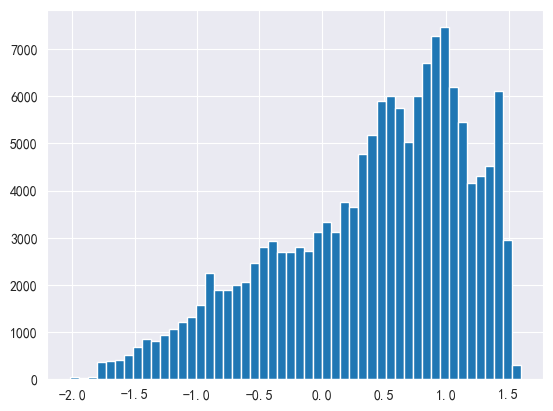

In [15]:
# DataLoader 是 python生成器，每次调用返回一个 batch 的数据
images, labels = next(iter(train_loader))
# 将数据集中的Tensor张量转为numpy的array数据类型
images = images.numpy()
plt.hist(images[5].flatten(), bins=50)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'label:1')

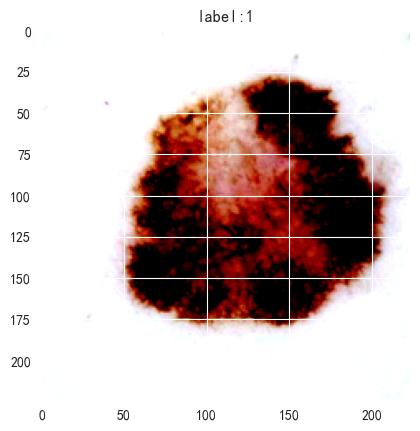

In [20]:
# batch 中经过预处理的图像
idx = 0
plt.imshow(images[idx].transpose((1,2,0))) # 转为(224, 224, 3)
plt.title('label:'+str(labels[idx].item()))

In [21]:
pred_classname = idx_to_labels[2]

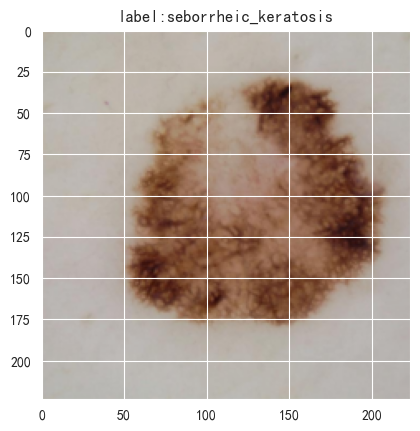

In [22]:
# 原始图像
idx = 0
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(np.clip(images[idx].transpose((1,2,0)) * std + mean, 0, 1))
plt.title('label:'+ pred_classname)
plt.show()

In [ ]:
model = models.resnet18(pretrained=True) # 载入预训练模型

# 修改全连接层，使得全连接层的输出与当前数据集类别数对应
# 新建的层默认 requires_grad=True
model.fc = nn.Linear(model.fc.in_features, n_class)

# 只微调训练最后一层全连接层的参数，其它层冻结
# optimizer = optim.Adam(model.fc.parameters())

# 微调训练所有层的参数
optimizer = optim.Adam(model.parameters())

### 训练配置

In [ ]:
model = model.to(device)

# 交叉熵损失函数
criterion = nn.CrossEntropyLoss()

# 训练轮次 Epoch
EPOCHS = 20

In [ ]:
# 遍历每个 EPOCH
for epoch in tqdm(range(EPOCHS)):

    model.train()

    for images, labels in train_loader:  # 获得一个 batch 的数据和标注
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels) # 计算当前 batch 中，每个样本的平均交叉熵损失函数值

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum()

    print('测试集上的准确率为 {:.3f} %'.format(100 * correct / total))

In [25]:
torch.save(model, 'checkpoints/isic_2017_20220814.pth')

NameError: name 'model' is not defined